# Spatial trajectory-based analysis

This tutorial demonstrates how to analyze feature changes along the trajectory inferred by ONTraC.

Features may include cell type composition, gene expression, regulon activity, or any other cell-level or niche-level scores.

## Load Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [2]:
from optparse import Values

In [3]:
from ONTraC.analysis.data import AnaData
from ONTraC.utils import write_version_info

write_version_info()

##################################################################################

         ▄▄█▀▀██   ▀█▄   ▀█▀ █▀▀██▀▀█                   ▄▄█▀▀▀▄█
        ▄█▀    ██   █▀█   █     ██    ▄▄▄ ▄▄   ▄▄▄▄   ▄█▀     ▀
        ██      ██  █ ▀█▄ █     ██     ██▀ ▀▀ ▀▀ ▄██  ██
        ▀█▄     ██  █   ███     ██     ██     ▄█▀ ██  ▀█▄      ▄
         ▀▀█▄▄▄█▀  ▄█▄   ▀█    ▄██▄   ▄██▄    ▀█▄▄▀█▀  ▀▀█▄▄▄▄▀

                        version: 1.2.2

##################################################################################


In [4]:
from ONTraC.analysis.trajectory import (construct_meta_cell_along_trajectory,
                                        cal_features_correlation_along_trajectory,
                                        plot_scatter_feat_along_trajectory,
                                        plot_cell_type_composition_along_trajectory_from_anadata,
                                        plot_cell_type_composition_along_trajectory)

In [5]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [6]:
import gseapy as gp

## Dataset Explanation

The Stereo-seq mouse embryonic midbrain dataset was originally published by [Chen, et al](https://doi.org/10.1016/j.cell.2022.04.003). The raw data could be download from [the MOSTA website](https://db.cngb.org/stomics/mosta/download/).

We assume that you have runned ONTraC on Stereo-seq mouse embryonic midbrain dataset according to our [example tutorial](../examples/Running_ONTraC_on_stereo_seq_dataset.ipynb).


## Load Data

### Download dataset

In [7]:
import requests

# URL of the file
url = "https://zenodo.org/records/15571644/files/Stereo_seq_data.zip"

# Local file path to save the file
file_path = "./Stereo_seq_data.zip"

try:
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    # Write the content to the file
    with open(file_path, "wb") as file:
        file.write(response.content)

    print(f"File downloaded and saved to {file_path}")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")


File downloaded and saved to ./Stereo_seq_data.zip


In [8]:
import zipfile

# Path to the zip file
zip_file_path = "Stereo_seq_data.zip"

# Directory where files will be extracted
extract_to_path = "./"

try:
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files to the specified directory
        zip_ref.extractall(extract_to_path)

    print(f"Files extracted to '{extract_to_path}'")
except zipfile.BadZipFile:
    print("The file is not a valid zip file.")


Files extracted to './'


### ONTraC output

In [9]:
vis_options = Values()
vis_options.NN_dir = './Stereo_seq_data/ONTraC_output/stereo_midbrain_base_NN/'
vis_options.GNN_dir = './Stereo_seq_data/ONTraC_output/stereo_midbrain_base_GNN/'
vis_options.NT_dir = './Stereo_seq_data/ONTraC_output/stereo_midbrain_base_NT/'
vis_options.reverse = True
vis_options.output = None

In [10]:
ana_data = AnaData(vis_options)

In [11]:
ana_data.meta_data_df.head()

,Sample,Cell_Type,x,y
Cell_ID,,,,
E12_E1S3_100034,E12_E1S3,Fibro,15940.0,18584.0
E12_E1S3_100035,E12_E1S3,Fibro,15942.0,18623.0
E12_E1S3_100191,E12_E1S3,Endo,15965.0,18619.0
E12_E1S3_100256,E12_E1S3,Fibro,15969.0,18717.0
E12_E1S3_100264,E12_E1S3,Fibro,15974.0,18692.0


### Differentiation potency

The differentialtion potency was calculated using [moscot](https://doi.org/10.1038/s41586-024-08453-2).

Please refer our [processing codes](https://github.com/gyuanlab/ONTraC_paper/blob/master/Stereo_seq_midbrain_data/post_analysis/MOSCOT/Moscot.ipynb) for details.

In [12]:
ot_res1 = pd.read_csv('./Stereo_seq_data/source/moscot/E14_E16_1_cm.csv.gz', index_col=0)
temp = pd.read_csv('./Stereo_seq_data/source/moscot/ss0_E14_E1S3_loc.csv.gz',index_col = 0)
ot_res1.index = temp.index
temp = pd.read_csv('./Stereo_seq_data/source/moscot/ss0_E16_E1S3_loc.csv.gz',index_col = 0)
ot_res1.columns = temp.index
ot_res1.head()

,E16_E1S3_21,E16_E1S3_22,E16_E1S3_23,E16_E1S3_26,E16_E1S3_27,E16_E1S3_28,E16_E1S3_29,E16_E1S3_31,E16_E1S3_32,E16_E1S3_33,...,E16_E1S3_6920,E16_E1S3_6921,E16_E1S3_6923,E16_E1S3_6924,E16_E1S3_6925,E16_E1S3_6926,E16_E1S3_6928,E16_E1S3_6929,E16_E1S3_6930,E16_E1S3_6931
E14_E1S3_170808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
E14_E1S3_170916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.345486e-31,0.0,0.000154,0.0,0.0,0.0,0.000000e+00,0.0,0.0,4.531762e-26
E14_E1S3_170934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,2.703351e-37,0.0,0.0,0.000000e+00
E14_E1S3_171016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00
E14_E1S3_171024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00


In [13]:
ot_res2 = pd.read_csv('./Stereo_seq_data/source/moscot/E14_E16_2_cm.csv.gz', index_col=0)
temp = pd.read_csv('./Stereo_seq_data/source/moscot/ss0_E14_E1S3_loc.csv.gz',index_col = 0)
ot_res2.index = temp.index
temp = pd.read_csv('./Stereo_seq_data/source/moscot/ss0_E16_E2S6_loc.csv.gz',index_col = 0)
ot_res2.columns = temp.index
ot_res2.head()

,E16_E2S6_119,E16_E2S6_147,E16_E2S6_164,E16_E2S6_193,E16_E2S6_199,E16_E2S6_203,E16_E2S6_217,E16_E2S6_222,E16_E2S6_230,E16_E2S6_234,...,E16_E2S6_36290,E16_E2S6_36348,E16_E2S6_36407,E16_E2S6_36523,E16_E2S6_36607,E16_E2S6_36632,E16_E2S6_36755,E16_E2S6_36782,E16_E2S6_36838,E16_E2S6_36891
E14_E1S3_170808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
E14_E1S3_170916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
E14_E1S3_170934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000112,0.000002,9.689674e-31,0.0,0.0,8.916933e-08,0.0,0.0,0.0
E14_E1S3_171016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,1.239693e-06,0.0,0.0,0.0
E14_E1S3_171024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0


In [14]:
ot_res3 = pd.read_csv('./Stereo_seq_data/source/moscot/E14_E16_3_cm.csv.gz', index_col=0)
temp = pd.read_csv('./Stereo_seq_data/source/moscot/ss0_E14_E1S3_loc.csv.gz',index_col = 0)
ot_res3.index = temp.index
temp = pd.read_csv('./Stereo_seq_data/source/moscot/ss0_E16_E2S7_loc.csv.gz',index_col = 0)
ot_res3.columns = temp.index
ot_res3.head()

,E16_E2S7_291152,E16_E2S7_291165,E16_E2S7_291300,E16_E2S7_291398,E16_E2S7_291435,E16_E2S7_291487,E16_E2S7_291503,E16_E2S7_291550,E16_E2S7_291585,E16_E2S7_291591,...,E16_E2S7_326320,E16_E2S7_326323,E16_E2S7_326324,E16_E2S7_326325,E16_E2S7_326329,E16_E2S7_326357,E16_E2S7_326359,E16_E2S7_326384,E16_E2S7_326391,E16_E2S7_326412
E14_E1S3_170808,0.0,1.598103e-18,0.0,0.0,7.107961e-09,0.0,1.541208e-25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E14_E1S3_170916,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E14_E1S3_170934,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E14_E1S3_171016,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E14_E1S3_171024,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Gene expression

In [15]:
E14_RGC_scaled_exp = pd.read_csv('./Stereo_seq_data/source/stereo_seq_E14_RGC_scaled_exp.csv.gz', index_col=0)
E14_RGC_scaled_exp.head()

,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610031O16Rik,...,Zw10,Zwilch,Zwint,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3
Cell_ID,,,,,,,,,,,,,,,,,,,,,
E14_E1S3_171289,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,3.277203,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.091104,-0.068489,-0.389927,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425
E14_E1S3_171863,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,-0.307818,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.091104,-0.068489,-0.389927,-0.073764,9.345431,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425
E14_E1S3_171967,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,-0.307818,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.091104,-0.068489,-0.389927,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425
E14_E1S3_171983,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,2.074143,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.091104,-0.068489,-0.389927,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425
E14_E1S3_172013,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,-0.307818,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.091104,-0.068489,-0.389927,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425


### Regulon activities

Regulon activities were calculated using [pySCENIC](https://doi.org/10.1038/nmeth.4463).

Please refer our [processing codes](https://github.com/gyuanlab/ONTraC_paper/blob/master/Stereo_seq_midbrain_data/post_analysis/SCENIC/Python_SCENIC.ipynb) for details.

In [16]:
regulon_aucell_df = pd.read_csv('./Stereo_seq_data/source/stereo_seq.auc.csv.gz', index_col=0)
regulon_aucell_df.head()

,Ahr,Alx1,Alx3,Alx4,Ar,Arid3a,Arntl2,Arx,Atf1,Atf3,...,Zfp821,Zfp874b,Zfp941,Zfp944,Zfp979,Zic1,Zkscan14,Zkscan16,Zscan20,Zxdc
Cell,,,,,,,,,,,,,,,,,,,,,
E12_E1S3_100034,0.0,0.014262,0.009032,0.038966,0.0,0.001760,0.0,0.000000,0.0,0.134952,...,0.0,0.000000,0.0,0.0,0.0,0.051056,0.045712,0.017288,0.0,0.0
E12_E1S3_100035,0.0,0.017741,0.017087,0.000000,0.0,0.003681,0.0,0.000000,0.0,0.167847,...,0.0,0.003940,0.0,0.0,0.0,0.064695,0.062440,0.026075,0.0,0.0
E12_E1S3_100191,0.0,0.009400,0.009933,0.026062,0.0,0.001426,0.0,0.000000,0.0,0.129891,...,0.0,0.000000,0.0,0.0,0.0,0.088422,0.042828,0.015757,0.0,0.0
E12_E1S3_100256,0.0,0.017928,0.017399,0.000000,0.0,0.003750,0.0,0.000000,0.0,0.168128,...,0.0,0.004096,0.0,0.0,0.0,0.048256,0.062728,0.091552,0.0,0.0
E12_E1S3_100264,0.0,0.019671,0.019565,0.042947,0.0,0.004231,0.0,0.080958,0.0,0.176000,...,0.0,0.005547,0.0,0.0,0.0,0.049611,0.066910,0.028448,0.0,0.0


### Msigdb gene sets

Please refer [release note](https://docs.gsea-msigdb.org/#MSigDB/Release_Notes/MSigDB_7.5) for details.

In [17]:
import requests

# URL of the file
url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.5.1/c5.go.bp.v7.5.1.symbols.gmt"

# Local file path to save the file
file_path = "./c5.go.bp.v7.5.1.symbols.gmt"

try:
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    # Write the content to the file
    with open(file_path, "wb") as file:
        file.write(response.content)

    print(f"File downloaded and saved to {file_path}")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")


File downloaded and saved to ./c5.go.bp.v7.5.1.symbols.gmt


## Dataset overview

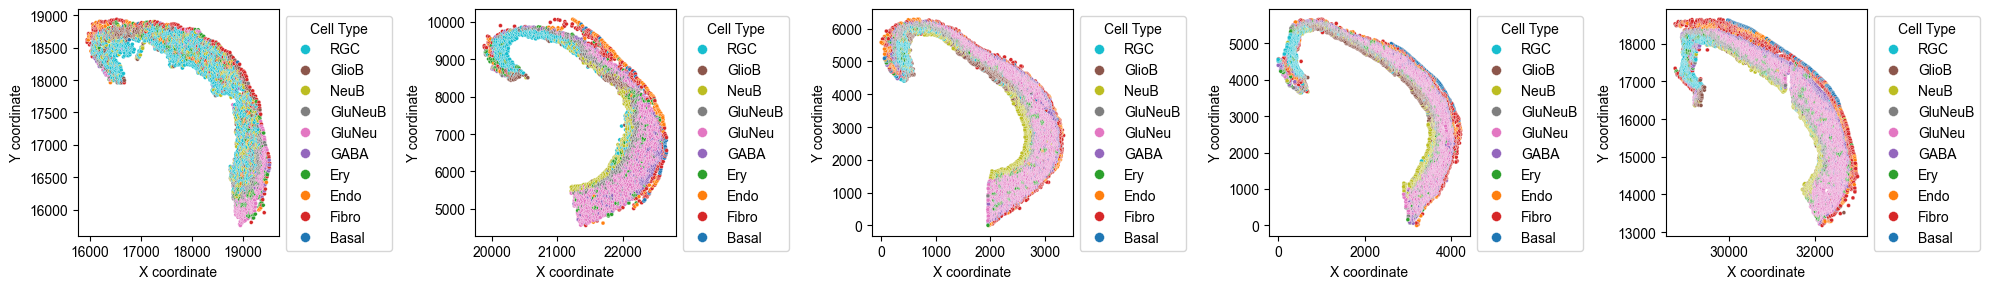

In [18]:
from ONTraC.analysis.cell_type import plot_spatial_cell_type_distribution_dataset_from_anadata

fig, axes = plot_spatial_cell_type_distribution_dataset_from_anadata(ana_data = ana_data,
                                                                     hue_order = ['RGC', 'GlioB', 'NeuB', 'GluNeuB', 'GluNeu', 'GABA', 'Ery', 'Endo', 'Fibro', 'Basal'])

for ax in axes:
    ax.legend(title='Cell Type', loc='upper left', bbox_to_anchor=(1,1), markerscale=2.5)
    # ax.set_aspect('equal', 'box')  # uncomment this line if you want set the x and y axis with same scaling
    # ax.set_xticks([])  # uncomment this line if you don't want to show x coordinates
    # ax.set_yticks([])  # uncomment this line if you don't want to show y coordinates
    # ax.invert_xaxis()  # uncomment this line if you want to invert x axis
    # ax.invert_yaxis()  # uncomment this line if you want to invert y axis
    
    pass

## Spatial distribution of NT scores

We visualize the spatial distribution of NT scores for each cell to illustrate the spatial trajectory.

## Spatial distribution of NT scores for all cells

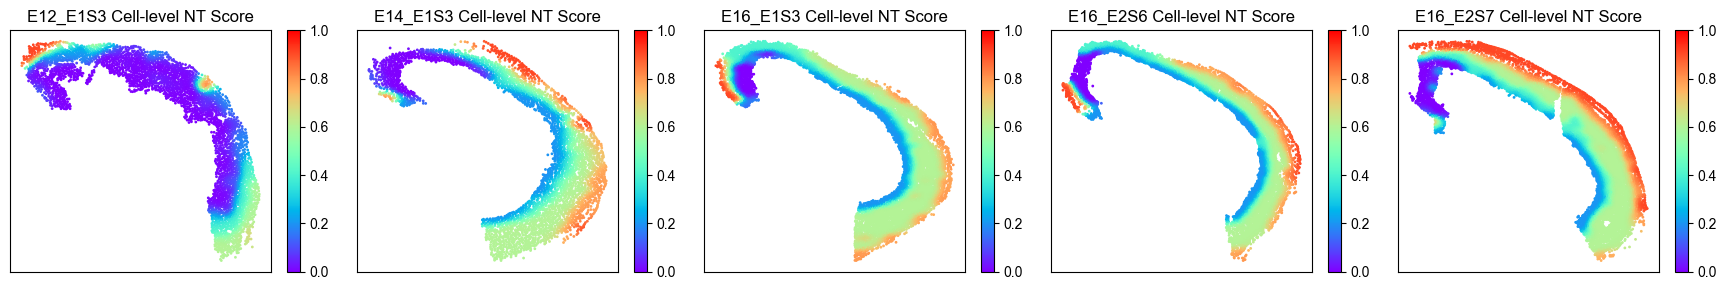

In [19]:
from ONTraC.analysis.spatial import plot_cell_NT_score_dataset_from_anadata

fig, axes = plot_cell_NT_score_dataset_from_anadata(ana_data)

## Spatial distribution of NT scores for E14.5 RGCs only

In [20]:
# Selecting E14.5 RGCs from the dataset
plot_meta_data = ana_data.meta_data_df[(ana_data.meta_data_df['Sample'] == 'E14_E1S3') & (ana_data.meta_data_df['Cell_Type'] == 'RGC')]
plot_meta_data.head()

,Sample,Cell_Type,x,y
Cell_ID,,,,
E14_E1S3_171289,E14_E1S3,RGC,19941.0,9116.0
E14_E1S3_171863,E14_E1S3,RGC,20024.0,9512.0
E14_E1S3_171967,E14_E1S3,RGC,20040.0,9397.0
E14_E1S3_171983,E14_E1S3,RGC,20040.0,9219.0
E14_E1S3_172013,E14_E1S3,RGC,20036.0,9352.0


In [21]:
plot_NT_score = ana_data.NT_score.loc[plot_meta_data.index]
plot_NT_score.head()

,x,y,Niche_NTScore,Cell_NTScore
Cell_ID,,,,
E14_E1S3_171289,19941.0,9116.0,0.862209,0.894205
E14_E1S3_171863,20024.0,9512.0,0.983229,0.979535
E14_E1S3_171967,20040.0,9397.0,0.994614,0.980553
E14_E1S3_171983,20040.0,9219.0,0.988135,0.958657
E14_E1S3_172013,20036.0,9352.0,0.994703,0.976718


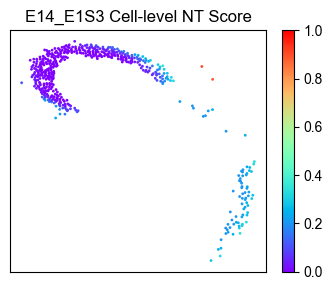

In [22]:
# visualization

from ONTraC.analysis.spatial import plot_cell_NT_score_dataset

fig, ax = plot_cell_NT_score_dataset(meta_data_df=plot_meta_data,
                                     NT_score=plot_NT_score,
                                     reverse=ana_data.options.reverse
                                   )

## Cell type composition along spatial trajcetory

Cell type composition along the spatial trajectory reflects changes in the microenvironment.

### Cell type composition change for all cells

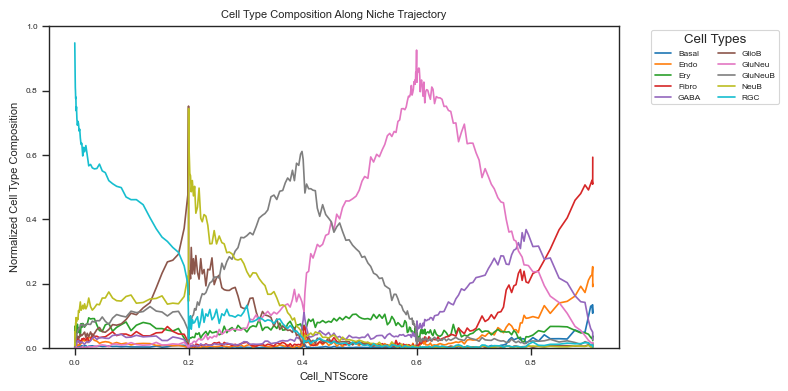

In [23]:
fig, ax = plot_cell_type_composition_along_trajectory_from_anadata(
    ana_data=ana_data,  # AnaData object
    cell_types=None,  # Column name(s) in AnaData.meta_data_df that contains the cell type information.
                      # Default is None, which means all cell types in AnaData.cell_type_codes will be used.
    agg_cell_num=100,  # Number of cells to aggregate in each bin along the trajectory. Default is 10. 1 means no aggregation.
    figsize=(8,4),  # Figure size. Default is (6, 2).
    palette=None,  # Color palette for cell types. If None, use default color palette. Keys are cell types and values are colors.
    output_file_path=None  # Path to save the figure. If None, the default path
                           # {ana_data.options.output}/lineplot_raw_cell_type_composition_along_trajectory.pdf is used. 
                           # If ana_data.options.output is also None, the figure will not be saved and the function 
                           # will return the figure and axes objects instead.
)

We observe that the dominant cell type shifts along the spatial trajectory, from RGCs (undifferentiated cells) to NeuB, GluNeuB, and ultimately to fully differentiated cells such as GluNeu and GABA neurons.

### Cell type composition change around RGCs only

In [24]:
# create data_df
data_df = ana_data.meta_data_df.copy()
data_df = data_df.join(1 - ana_data.NT_score['Cell_NTScore'] if hasattr(ana_data.options, 'reverse')
                       and ana_data.options.reverse else ana_data.NT_score['Cell_NTScore'])
data_df = data_df.join(ana_data.cell_type_composition)

In [25]:
# filtering with cell type
data_df = data_df[data_df['Cell_Type'] == 'RGC']

In [26]:
cell_types = ana_data.cell_type_codes['Cell_Type'].values.tolist()

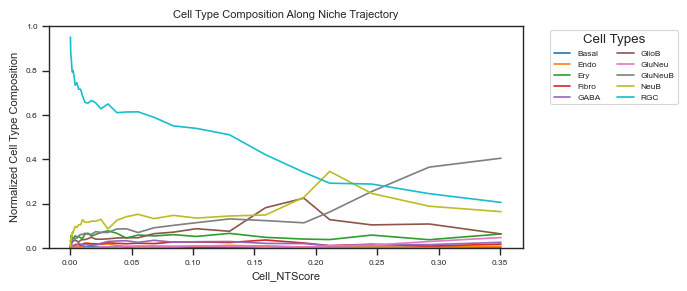

In [27]:
fig ,ax = plot_cell_type_composition_along_trajectory(
    data_df=data_df,
    trajectory='Cell_NTScore',
    cell_types=cell_types, # type: ignore
    agg_cell_num=100,
    figsize=(7,3),
    palette=None,
    output_file_path=None,
)

In E14.5, RGCs are primarily located within RGC-dominant microenvironments. Along the spatial trajectory, the proportion of RGCs gradually decreases, while NeuB and GluNeuB cells increase sequentially.
We will explore the features associated with this dynamic in the following sections.

## Differentiation potency along trajectory

We can investigate differentiation potency by using [Moscot](https://moscot.readthedocs.io/en/latest/) to predict the potential offspring of RGCs in the next stage (E16.5).
The Moscot output have been loaded in previous section.

Selecting RGCs from Moscot results and aggregate replicates information

In [28]:
target_cells = ana_data.meta_data_df[(ana_data.meta_data_df['Cell_Type'] == 'RGC') & (ana_data.meta_data_df['Sample'] == 'E14_E1S3')]

In [29]:
def ot_res_process(ot_res):
    ot_res = ot_res.loc[ot_res.index.isin(ana_data.meta_data_df.index),
                       ot_res.columns.isin(ana_data.meta_data_df.index)]
    top_5_indices = ot_res.apply(lambda row: row.nlargest(5).index, axis=1)
    top_5_cell_types = top_5_indices.apply(lambda x: ana_data.meta_data_df.loc[x, 'Cell_Type'])
    summary_df = top_5_cell_types.apply(lambda x: x.value_counts(), axis=1).fillna(0).astype(int)
    summary_df = summary_df.loc[target_cells.index]
    summary_df = summary_df.div(summary_df.sum(axis=1).values, axis=0)
    summary_df = summary_df.join(1-ana_data.NT_score['Cell_NTScore'] if hasattr(ana_data.options, 'reverse')
                       and ana_data.options.reverse else ana_data.NT_score['Cell_NTScore'])
    
    return summary_df
    

In [30]:
summary_df_1 = ot_res_process(ot_res1)
summary_df_1.head()


,Basal,Endo,Ery,Fibro,GABA,GlioB,GluNeu,GluNeuB,NeuB,RGC,Cell_NTScore
Cell_ID,,,,,,,,,,,
E14_E1S3_171289,0.0,0.0,0.0,0.2,0.4,0.0,0.0,0.0,0.0,0.4,0.105795
E14_E1S3_171863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.020465
E14_E1S3_171967,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.6,0.0,0.0,0.019447
E14_E1S3_171983,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.8,0.0,0.0,0.041343
E14_E1S3_172013,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.4,0.0,0.4,0.023282


In [31]:
E14_RGC_metacell_diff_p_1_df = construct_meta_cell_along_trajectory(
    meta_data_df = summary_df_1,
    trajectory = 'Cell_NTScore',
    n_cells = 10)
E14_RGC_metacell_diff_p_1_df.head()

,Basal,Endo,Ery,Fibro,GABA,GlioB,GluNeu,GluNeuB,NeuB,RGC,Cell_NTScore
Cell_ID,,,,,,,,,,,
E14_E1S3_173789,0.0,0.0,0.00,0.00,0.02,0.16,0.00,0.14,0.30,0.38,0.000230
E14_E1S3_173259,0.0,0.0,0.00,0.02,0.00,0.16,0.02,0.22,0.20,0.38,0.000240
E14_E1S3_174106,0.0,0.0,0.02,0.00,0.00,0.06,0.02,0.24,0.16,0.50,0.000250
E14_E1S3_173417,0.0,0.0,0.00,0.02,0.08,0.14,0.02,0.30,0.04,0.40,0.000266
E14_E1S3_173284,0.0,0.0,0.06,0.00,0.08,0.10,0.02,0.24,0.16,0.34,0.000285


In [32]:
summary_df_2 = ot_res_process(ot_res2)
E14_RGC_metacell_diff_p_2_df = construct_meta_cell_along_trajectory(
    meta_data_df = summary_df_2,
    trajectory = 'Cell_NTScore',
    n_cells = 10)
E14_RGC_metacell_diff_p_2_df.head()


,Basal,Endo,Ery,Fibro,GABA,GlioB,GluNeu,GluNeuB,NeuB,RGC,Cell_NTScore
Cell_ID,,,,,,,,,,,
E14_E1S3_173789,0.0,0.0,0.02,0.06,0.12,0.12,0.02,0.06,0.10,0.50,0.000230
E14_E1S3_173259,0.0,0.0,0.00,0.00,0.08,0.14,0.00,0.04,0.14,0.60,0.000240
E14_E1S3_174106,0.0,0.0,0.02,0.04,0.04,0.00,0.02,0.08,0.12,0.68,0.000250
E14_E1S3_173417,0.0,0.0,0.02,0.00,0.04,0.14,0.00,0.08,0.06,0.66,0.000266
E14_E1S3_173284,0.0,0.0,0.00,0.02,0.10,0.12,0.02,0.08,0.08,0.58,0.000285


In [33]:
summary_df_3 = ot_res_process(ot_res3)
E14_RGC_metacell_diff_p_3_df = construct_meta_cell_along_trajectory(
    meta_data_df = summary_df_3,
    trajectory = 'Cell_NTScore',
    n_cells = 10)
E14_RGC_metacell_diff_p_3_df.head()


,Basal,Endo,Ery,Fibro,GABA,GlioB,GluNeu,GluNeuB,NeuB,RGC,Cell_NTScore
Cell_ID,,,,,,,,,,,
E14_E1S3_173789,0.00,0.0,0.00,0.12,0.02,0.02,0.04,0.10,0.04,0.66,0.000230
E14_E1S3_173259,0.02,0.0,0.02,0.04,0.02,0.02,0.00,0.06,0.02,0.80,0.000240
E14_E1S3_174106,0.00,0.0,0.12,0.06,0.08,0.02,0.02,0.08,0.00,0.62,0.000250
E14_E1S3_173417,0.02,0.0,0.04,0.06,0.04,0.02,0.04,0.14,0.00,0.64,0.000266
E14_E1S3_173284,0.00,0.0,0.02,0.06,0.12,0.04,0.08,0.20,0.00,0.48,0.000285


In [34]:
E14_RGC_metacell_diff_p_1_melted_df = E14_RGC_metacell_diff_p_1_df.melt(
    id_vars='Cell_NTScore',
    value_vars=E14_RGC_metacell_diff_p_1_df.columns.tolist()[:-1],
    var_name='Cell type',
    value_name='Proportion')
E14_RGC_metacell_diff_p_1_melted_df['replicate'] = ['rep1'] * E14_RGC_metacell_diff_p_1_melted_df.shape[0]
E14_RGC_metacell_diff_p_1_melted_df.head()


,Cell_NTScore,Cell type,Proportion,replicate
0,0.000230,Basal,0.0,rep1
1,0.000240,Basal,0.0,rep1
2,0.000250,Basal,0.0,rep1
3,0.000266,Basal,0.0,rep1
4,0.000285,Basal,0.0,rep1


In [35]:
E14_RGC_metacell_diff_p_2_melted_df = E14_RGC_metacell_diff_p_2_df.melt(
    id_vars='Cell_NTScore',
    value_vars=E14_RGC_metacell_diff_p_2_df.columns.tolist()[:-1],
    var_name='Cell type',
    value_name='Proportion')
E14_RGC_metacell_diff_p_2_melted_df['replicate'] = ['rep2'] * E14_RGC_metacell_diff_p_2_melted_df.shape[0]
E14_RGC_metacell_diff_p_2_melted_df.head()


,Cell_NTScore,Cell type,Proportion,replicate
0,0.000230,Basal,0.0,rep2
1,0.000240,Basal,0.0,rep2
2,0.000250,Basal,0.0,rep2
3,0.000266,Basal,0.0,rep2
4,0.000285,Basal,0.0,rep2


In [36]:
E14_RGC_metacell_diff_p_3_melted_df = E14_RGC_metacell_diff_p_3_df.melt(
    id_vars='Cell_NTScore',
    value_vars=E14_RGC_metacell_diff_p_3_df.columns.tolist()[:-1],
    var_name='Cell type',
    value_name='Proportion')
E14_RGC_metacell_diff_p_3_melted_df['replicate'] = ['rep3'] * E14_RGC_metacell_diff_p_3_melted_df.shape[0]
E14_RGC_metacell_diff_p_3_melted_df.head()


,Cell_NTScore,Cell type,Proportion,replicate
0,0.000230,Basal,0.00,rep3
1,0.000240,Basal,0.02,rep3
2,0.000250,Basal,0.00,rep3
3,0.000266,Basal,0.02,rep3
4,0.000285,Basal,0.00,rep3


In [37]:
E14_RGC_metacell_diff_p_melted = pd.concat([E14_RGC_metacell_diff_p_1_melted_df,
                                            E14_RGC_metacell_diff_p_2_melted_df,
                                            E14_RGC_metacell_diff_p_3_melted_df])
E14_RGC_metacell_diff_p_melted.head()

,Cell_NTScore,Cell type,Proportion,replicate
0,0.000230,Basal,0.0,rep1
1,0.000240,Basal,0.0,rep1
2,0.000250,Basal,0.0,rep1
3,0.000266,Basal,0.0,rep1
4,0.000285,Basal,0.0,rep1


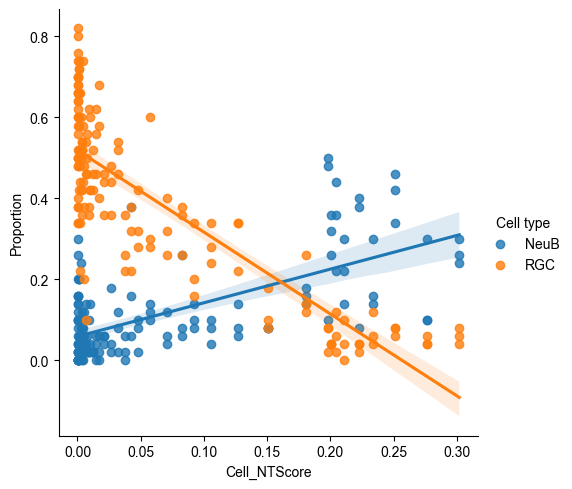

In [38]:
sns.lmplot(data = E14_RGC_metacell_diff_p_melted[E14_RGC_metacell_diff_p_melted['Cell type'].isin(['RGC', 'NeuB'])],
           x = 'Cell_NTScore',
           y = 'Proportion',
           hue = 'Cell type',
           scatter_kws={'edgecolor': None},
           ci=95,
          )

Along the spatial trajectory, the probability of RGCs maintaining their identity decreases, while the probability of their differentiation into NeuB increases.

## Gene expression changes along spatial trajectory

Next, we explore gene expression dynamics along the spatial trajectory.

In [39]:
E14_RGC_gene_exp_df = E14_RGC_scaled_exp.join(1 - ana_data.NT_score['Cell_NTScore'] if hasattr(ana_data.options, 'reverse')
                       and ana_data.options.reverse else ana_data.NT_score['Cell_NTScore'])

In [40]:
# The meta-cell could reduce the noise here
E14_RGC_gene_exp_metacell_data_df = construct_meta_cell_along_trajectory(
    meta_data_df = E14_RGC_gene_exp_df,
    trajectory = 'Cell_NTScore',
    n_cells = 10
)
E14_RGC_gene_exp_metacell_data_df.head()


,0610005C13Rik,0610006L08Rik,0610009B22Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610031O16Rik,...,Zwilch,Zwint,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,Cell_NTScore
Cell_ID,,,,,,,,,,,,,,,,,,,,,
E14_E1S3_173789,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,-0.098032,0.516922,-0.025192,-0.088172,-0.008486,...,0.938360,0.371673,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,0.353277,0.000230
E14_E1S3_173259,-0.036511,-0.008535,-0.198124,-0.106792,0.117162,0.537851,-0.049493,-0.025192,-0.088172,-0.008486,...,-0.068489,0.011324,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,0.946734,-0.199425,0.000240
E14_E1S3_174106,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,-0.093338,0.008216,-0.025192,-0.088172,-0.008486,...,-0.068489,-0.117173,0.933613,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,0.234650,0.000250
E14_E1S3_173417,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,-0.064664,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.068489,-0.081511,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425,0.000266
E14_E1S3_173284,-0.036511,-0.008535,-0.198124,-0.106792,-0.239179,0.321239,-0.321011,-0.025192,-0.088172,-0.008486,...,-0.068489,-0.389927,-0.073764,-0.117644,-0.043855,-0.223836,-0.21233,-0.148131,-0.199425,0.000285


In [41]:
gene_correlated_df = cal_features_correlation_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    rho_threshold=0.4,
    p_val_threshold=0.01
)
print(gene_correlated_df.shape)

/sc/arion/work/wangw32/conda-env/envs/ONTraC/lib/python3.11/site-packages/ONTraC/analysis/trajectory.py:102: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_val = pearsonr(data_df[trajectory], data_df[feat])


(109, 2)


We identified 109 genes whose expression levels are significantly correlated with cell-level NT scores.
Here, we highlight six representative genes that are strongly associated with neuronal differentiation and maturation.

In [42]:
gene_correlated_df.head()

,PCC,P_Value
Feature,,
Cdkn1c,0.629617,9.666948e-07
Gm3764,0.623302,1.333598e-06
Lbh,0.618297,1.712368e-06
Bbs9,0.550067,3.502920e-05
Phf21b,0.542046,4.788367e-05


### Different Filtering Parameters

You can also select top N genes by following command:

In [43]:
cal_features_correlation_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    top_n=5,
    rho_threshold=0.4,
    p_val_threshold=0.01
)

/sc/arion/work/wangw32/conda-env/envs/ONTraC/lib/python3.11/site-packages/ONTraC/analysis/trajectory.py:102: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_val = pearsonr(data_df[trajectory], data_df[feat])


,PCC,P_Value
Feature,,
Cdkn1c,0.629617,9.666948e-07
Gm3764,0.623302,1.333598e-06
Lbh,0.618297,1.712368e-06
Bbs9,0.550067,3.502920e-05
Phf21b,0.542046,4.788367e-05
Mcm3,-0.453214,9.492690e-04
Eif2s2,-0.456194,8.696506e-04
Tuba1b,-0.470727,5.608145e-04
Ccnd2,-0.479827,4.218648e-04


### Heatmap Showing Trajectory-Associated Genes

In [44]:
filtered_metacell_gene_exp_df = E14_RGC_gene_exp_metacell_data_df.loc[:,gene_correlated_df.index]
filtered_metacell_gene_exp_df.head()

Feature,Cdkn1c,Gm3764,Lbh,Bbs9,Phf21b,Helt,Nkain3,Pgpep1,Rhbdl3,Akr1b8,...,Cd24a,Rps8,Rpl22l1,Rpl19,Phgdh,Mcm3,Eif2s2,Tuba1b,Ccnd2,Ppia
Cell_ID,,,,,,,,,,,,,,,,,,,,,
E14_E1S3_173789,-0.126359,-0.152949,0.148899,-0.111262,-0.150273,-0.108984,-0.237243,-0.167096,-0.122761,-0.052675,...,-0.418015,0.575271,0.220949,0.309830,0.164429,-0.159499,0.234015,0.449034,0.433422,0.543230
E14_E1S3_173259,-0.570163,-0.152949,-0.192196,-0.111262,-0.150273,-0.108984,-0.237243,-0.167096,-0.122761,-0.052675,...,-0.251175,0.916426,0.492244,0.625080,1.361812,0.350744,0.431511,0.532895,0.642079,0.112190
E14_E1S3_174106,-0.570163,-0.152949,-0.192196,-0.111262,-0.150273,-0.108984,-0.237243,-0.167096,-0.122761,-0.052675,...,-0.207797,0.531247,-0.033359,0.499405,1.262983,1.341346,0.214287,0.608114,-0.371306,0.839393
E14_E1S3_173417,-0.570163,-0.152949,-0.192196,-0.111262,-0.150273,-0.108984,-0.237243,-0.167096,-0.122761,-0.052675,...,-0.593854,0.697930,0.274315,-0.226063,-0.240031,1.718599,-0.099978,0.528772,0.449835,0.103245
E14_E1S3_173284,-0.570163,-0.152949,-0.192196,-0.111262,-0.150273,-0.108984,-0.237243,-0.167096,-0.122761,-0.052675,...,-0.371482,0.731672,0.595815,0.640199,0.716297,1.006487,0.340025,0.822160,0.210475,0.089651


Text(33.222222222222214, 0.5, 'Genes')

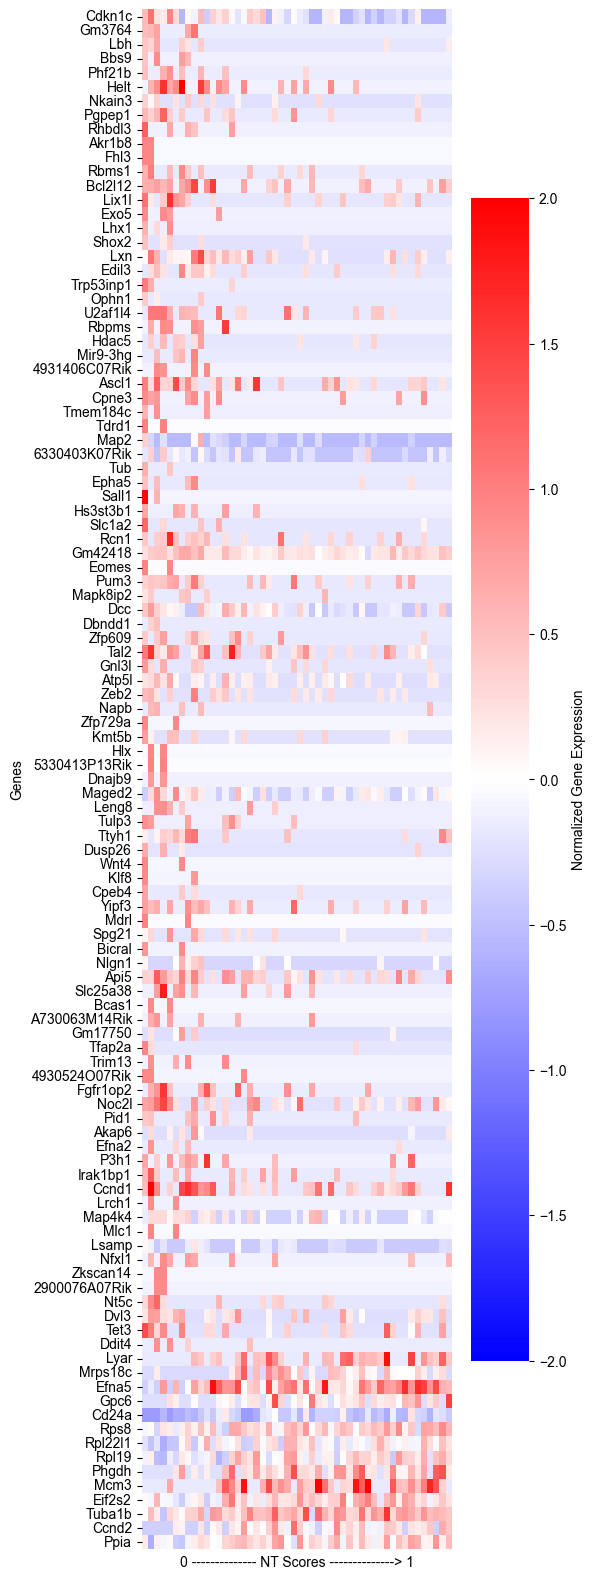

In [45]:
fig, ax = plt.subplots(figsize=(5, 20))
sns.heatmap(filtered_metacell_gene_exp_df.iloc[::-1,].T,
            cmap='bwr',
            vmin=-2,
            vmax=2,
            cbar_kws={'label': 'Normalized Gene Expression'},
            ax=ax)
ax.set_xticks([])
ax.set_xlabel('0 -------------- NT Scores --------------> 1')
ax.set_ylabel('Genes')

### Diagnosis of Selected Genes

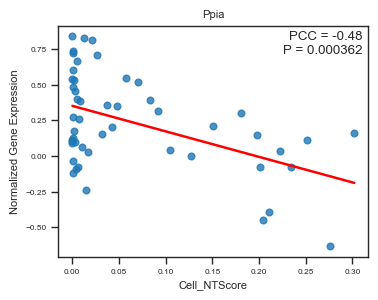

In [46]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Ppia',
    fit_reg = True,
    annotate_pos = 'upper right',
    figszie = (4,3),
    ylabel = 'Normalized Gene Expression',
)

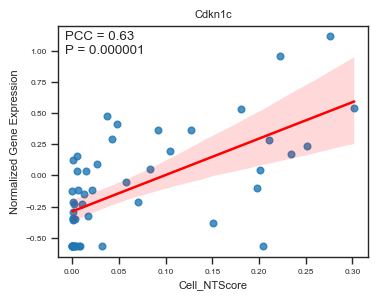

In [47]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Cdkn1c',
    fit_reg = True,
    annotate_pos = 'upper left',
    figszie = (4,3),
    ylabel = 'Normalized Gene Expression',
    ci=95,  # Size of the confidence interval for the regression estimate
)

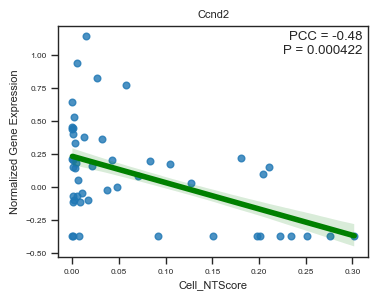

In [48]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Ccnd2',
    fit_reg = True,
    annotate_pos = 'upper right',
    figszie = (4,3),
    ylabel = 'Normalized Gene Expression',
    line_kws = {'color': 'green', 'lw': 4},  # line parameters
    ci=70,  # Size of the confidence interval for the regression estimate
)

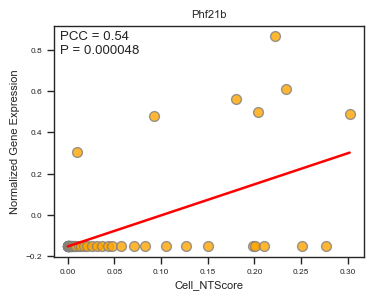

In [49]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Phf21b',
    fit_reg = True,
    annotate_pos = 'upper left',
    figszie = (4,3),
    ylabel = 'Normalized Gene Expression',
    scatter_kws = {'color': 'orange', 'edgecolor': 'gray', 's': 50},  # scatter parameters
)

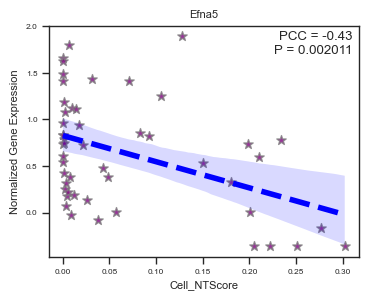

In [50]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Efna5',
    fit_reg = True,
    annotate_pos = 'upper right',
    figszie = (4,3),
    ylabel = 'Normalized Gene Expression',
    scatter_kws = {'color': 'purple', 'edgecolor': 'gray', 's': 50},  # scatter parameters
    line_kws = {'color': 'blue', 'lw': 4, 'ls': '--'},  # line parameters
    ci = 95,  # Size of the confidence interval for the regression estimate
    marker = '*',  # Marker to use for the scatterplot glyphs.
)

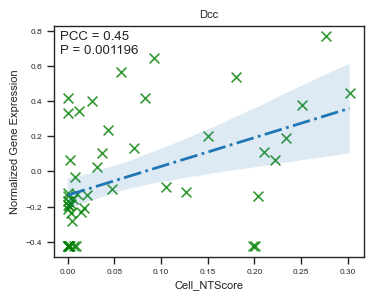

In [51]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Dcc',
    fit_reg = True,
    annotate_pos = 'upper left',
    figszie = (4,3),
    ylabel = 'Normalized Gene Expression',
    scatter_kws = {'color': 'green', 's': 50},  # scatter parameters
    line_kws = {'color': 'C0', 'lw': 2, 'ls': '-.'},  # line parameters
    ci = 95,  # Size of the confidence interval for the regression estimate.
    marker = 'x',  # Marker to use for the scatterplot glyphs.
)

## Gene Set Enrichment Analysis (GSEA)

In [52]:
# keep all genes while calculate correlation
all_gene_correlation_df = cal_features_correlation_along_trajectory(
    data_df = E14_RGC_gene_exp_metacell_data_df,
    trajectory = 'Cell_NTScore',
)
print(all_gene_correlation_df.shape)

/sc/arion/work/wangw32/conda-env/envs/ONTraC/lib/python3.11/site-packages/ONTraC/analysis/trajectory.py:102: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_val = pearsonr(data_df[trajectory], data_df[feat])


(13636, 2)


In [53]:
all_gene_correlation_df.head()

,PCC,P_Value
Feature,,
Cdkn1c,0.629617,9.666948e-07
Gm3764,0.623302,1.333598e-06
Lbh,0.618297,1.712368e-06
Bbs9,0.550067,3.502920e-05
Phf21b,0.542046,4.788367e-05


In [54]:
all_gene_correlation_df.tail()

,PCC,P_Value
Feature,,
Mcm3,-0.453214,0.000949
Eif2s2,-0.456194,0.000870
Tuba1b,-0.470727,0.000561
Ccnd2,-0.479827,0.000422
Ppia,-0.484622,0.000362


In [55]:
reject, qvals, _, _ = multipletests(all_gene_correlation_df['P_Value'].values, alpha=0.05, method="fdr_bh")
all_gene_correlation_df.loc[:,'FDR Q-Value'] = qvals
all_gene_correlation_df.head()

,PCC,P_Value,FDR Q-Value
Feature,,,
Cdkn1c,0.629617,9.666948e-07,0.007783
Gm3764,0.623302,1.333598e-06,0.007783
Lbh,0.618297,1.712368e-06,0.007783
Bbs9,0.550067,3.502920e-05,0.119415
Phf21b,0.542046,4.788367e-05,0.130588


In [56]:
all_gene_correlation_df.tail()

,PCC,P_Value,FDR Q-Value
Feature,,,
Mcm3,-0.453214,0.000949,0.311213
Eif2s2,-0.456194,0.000870,0.311213
Tuba1b,-0.470727,0.000561,0.275297
Ccnd2,-0.479827,0.000422,0.225432
Ppia,-0.484622,0.000362,0.224330


In [57]:
# corrected, only one columns should list here, otherwise, there are multiple ranks as inputs
corr_rnk = all_gene_correlation_df.iloc[:,:1]
corr_rnk.head()

,PCC
Feature,
Cdkn1c,0.629617
Gm3764,0.623302
Lbh,0.618297
Bbs9,0.550067
Phf21b,0.542046


In [58]:
corr_rnk.tail()

,PCC
Feature,
Mcm3,-0.453214
Eif2s2,-0.456194
Tuba1b,-0.470727
Ccnd2,-0.479827
Ppia,-0.484622


In [59]:
pre_res = gp.prerank(rnk=corr_rnk, # or rnk = rnk,
                     gene_sets='./c5.go.bp.v7.5.1.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2025-08-24 12:13:10,204 [WARNING] Duplicated values found in preranked stats: 16.66% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-24 12:13:10,204 [INFO] Parsing data files for GSEA.............................
2025-08-24 12:13:10,381 [INFO] 1188 gene_sets have been filtered out when max_size=1000 and min_size=5
2025-08-24 12:13:10,382 [INFO] 6470 gene_sets used for further statistical testing.....
2025-08-24 12:13:10,382 [INFO] Start to run GSEA...Might take a while..................
2025-08-24 12:13:10,383 [INFO] Genes are converted to uppercase.
2025-08-24 12:14:15,539 [INFO] Congratulations. GSEApy runs successfully................



In [60]:
res = pre_res.res2d
filter_res = res[[True if x.startswith('GOBP') else False for x in res['Term']]]
filter_res = filter_res[filter_res['NOM p-val'] < 0.05]

In [61]:
filter_res.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOBP_CYTOPLASMIC_TRANSLATION,-0.449215,-2.385238,0.0,0.004127,0.004,58/135,20.85%,Eif2s2;Rpl19;Rpl22l1;Rps8;Rpl3;Rps23;Rpl8;Rpl4...
1,prerank,GOBP_TRICARBOXYLIC_ACID_CYCLE,-0.624419,-2.374058,0.0,0.002579,0.004,9/27,6.50%,Idh2;Sdhd;Suclg2;Dlat;Idh3a;Mrps36;Dlst;Pdhb;Cs
2,prerank,GOBP_DNA_REPLICATION_INITIATION,-0.57303,-2.36083,0.0,0.00172,0.004,12/35,11.85%,Mcm3;Mcm5;Topbp1;Pola1;Prim2;Mcm2;Ccne2;Mcm6;M...
3,prerank,GOBP_DNA_UNWINDING_INVOLVED_IN_DNA_REPLICATION,-0.667623,-2.270939,0.0,0.006965,0.026,12/20,17.51%,Mcm3;Mcm5;Gins2;Blm;Mcm2;Mcm6;Twnk;Cdc45;Gins4...
4,prerank,GOBP_DNA_DEPENDENT_DNA_REPLICATION,-0.4078,-2.236996,0.0,0.00908,0.039,57/144,21.58%,Mcm3;Mcm5;Topbp1;Pola1;Gins2;Blm;Eme1;Rfc1;Cdk...


In [62]:
filter_res.sort_values('NES').head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOBP_CYTOPLASMIC_TRANSLATION,-0.449215,-2.385238,0.0,0.004127,0.004,58/135,20.85%,Eif2s2;Rpl19;Rpl22l1;Rps8;Rpl3;Rps23;Rpl8;Rpl4...
1,prerank,GOBP_TRICARBOXYLIC_ACID_CYCLE,-0.624419,-2.374058,0.0,0.002579,0.004,9/27,6.50%,Idh2;Sdhd;Suclg2;Dlat;Idh3a;Mrps36;Dlst;Pdhb;Cs
2,prerank,GOBP_DNA_REPLICATION_INITIATION,-0.57303,-2.36083,0.0,0.00172,0.004,12/35,11.85%,Mcm3;Mcm5;Topbp1;Pola1;Prim2;Mcm2;Ccne2;Mcm6;M...
3,prerank,GOBP_DNA_UNWINDING_INVOLVED_IN_DNA_REPLICATION,-0.667623,-2.270939,0.0,0.006965,0.026,12/20,17.51%,Mcm3;Mcm5;Gins2;Blm;Mcm2;Mcm6;Twnk;Cdc45;Gins4...
4,prerank,GOBP_DNA_DEPENDENT_DNA_REPLICATION,-0.4078,-2.236996,0.0,0.00908,0.039,57/144,21.58%,Mcm3;Mcm5;Topbp1;Pola1;Gins2;Blm;Eme1;Rfc1;Cdk...
5,prerank,GOBP_DOUBLE_STRAND_BREAK_REPAIR_VIA_BREAK_INDU...,-0.78386,-2.145294,0.0,0.036972,0.174,10/11,20.09%,Mcm3;Mcm5;Gins2;Mcm2;Mcm6;Cdc45;Gins4;Mcm7;Cdc...
6,prerank,GOBP_NEGATIVE_REGULATION_OF_RNA_SPLICING,-0.572831,-2.084832,0.0,0.069129,0.338,10/25,13.52%,Srsf4;Ptbp1;Hnrnpa2b1;Srsf7;C1qbp;Sap18;Rps26;...
7,prerank,GOBP_DNA_REPLICATION,-0.351203,-2.077697,0.0,0.066808,0.37,99/253,23.39%,Mcm3;Mcm5;Set;Topbp1;Pola1;Nasp;Gins2;Blm;Rrm2...
8,prerank,GOBP_CHROMATIN_REMODELING_AT_CENTROMERE,-0.762886,-2.074276,0.0,0.062136,0.383,5/9,6.65%,Hells;Nasp;Hjurp;Mis18a;Oip5
9,prerank,GOBP_DNA_GEOMETRIC_CHANGE,-0.407036,-2.048352,0.0,0.07728,0.47,30/85,15.53%,Mcm3;Mcm5;Gins2;Blm;Dscc1;Hnrnpa2b1;Brip1;Mcm2...


In [63]:
filter_res.sort_values('NES').tail(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
92,prerank,GOBP_POSITIVE_REGULATION_OF_HAIR_FOLLICLE_DEVE...,0.725166,1.743163,0.005639,1.0,1.0,3/8,4.61%,Tgfb2;Gal;Krt17
86,prerank,GOBP_REGULATION_OF_PROTEIN_LOCALIZATION_TO_CEN...,0.6737,1.750461,0.010949,1.0,1.0,6/10,11.80%,Bicd1;Cep250;Mark4;Nup62;Pard6a;Ubxn2b
83,prerank,GOBP_PLANAR_CELL_POLARITY_PATHWAY_INVOLVED_IN_...,0.661712,1.751047,0.015652,1.0,1.0,6/11,16.61%,Dvl3;Sfrp2;Fzd1;Dvl1;Nphp3;Sfrp1
77,prerank,GOBP_OLFACTORY_LOBE_DEVELOPMENT,0.498639,1.761532,0.006319,1.0,1.0,10/30,12.64%,Sall1;Eomes;Efna2;Slit1;Chd7;Srf;Erbb4;Robo1;R...
74,prerank,GOBP_REGULATION_OF_FATTY_ACID_BETA_OXIDATION,0.570444,1.76705,0.008606,1.0,1.0,8/17,15.92%,Etfbkmt;Cnr1;Abcd2;Lonp2;Irs1;Mlycd;Tysnd1;Acacb
71,prerank,GOBP_NEGATIVE_REGULATION_OF_COLLATERAL_SPROUTING,0.731298,1.773559,0.007707,1.0,1.0,6/8,16.75%,Dcc;Ptprs;Spp1;Ulk1;Epha7;Ulk2
68,prerank,GOBP_ANTERIOR_POSTERIOR_AXON_GUIDANCE,0.756514,1.780581,0.0,1.0,1.0,3/7,1.69%,Lhx1;Dcc;Lhx9
65,prerank,GOBP_REGULATION_OF_NEURON_PROJECTION_ARBORIZATION,0.621632,1.78363,0.003656,1.0,1.0,6/13,18.11%,Dvl3;Dlg4;Macf1;Dvl1;Map3k13;Ntng1
62,prerank,GOBP_NON_CANONICAL_WNT_SIGNALING_PATHWAY_VIA_M...,0.807137,1.796288,0.001919,1.0,1.0,3/6,0.70%,Wnt4;Dvl3;Nkd1
58,prerank,GOBP_FEEDING_BEHAVIOR,0.448003,1.800532,0.002899,1.0,1.0,15/53,12.48%,Helt;Dach1;Cck;Cnr1;Lepr;Ttc21b;Npy;Gal;Fyn;Po...


/sc/arion/work/wangw32/conda-env/envs/ONTraC/lib/python3.11/site-packages/gseapy/plot.py:738: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.colname] = df[self.colname].replace(0, np.nan).bfill()


<Axes: xlabel='NES'>

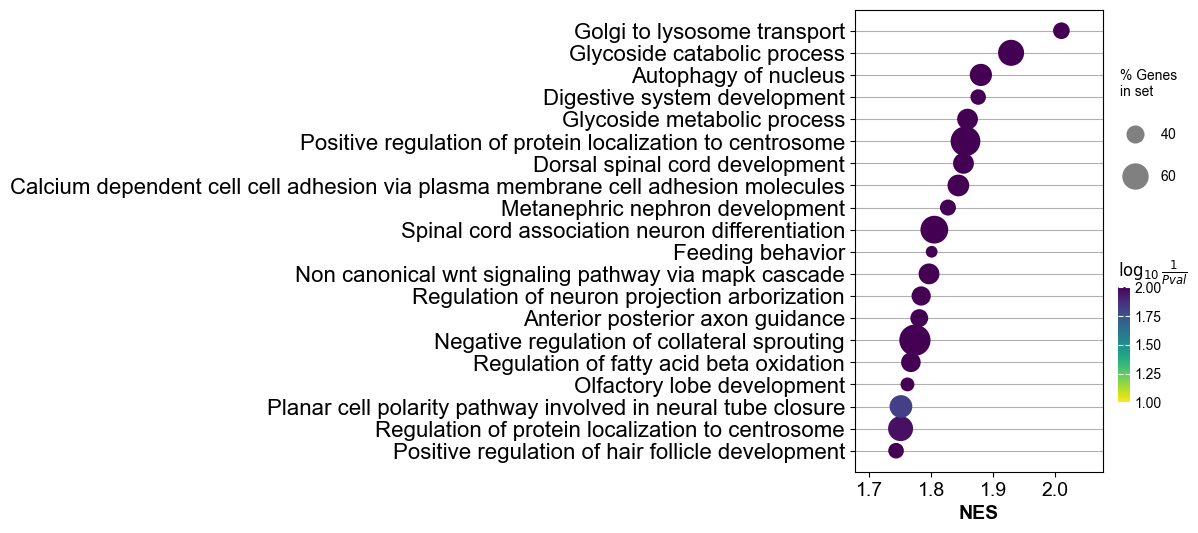

In [64]:
plot_data = filter_res.sort_values('NES').tail(20)
plot_data['Term'] = [x.split('_',1)[1].replace('_', ' ').capitalize() for x in plot_data['Term']]

gp.dotplot(plot_data,column="NOM p-val",top_term=20)

/sc/arion/work/wangw32/conda-env/envs/ONTraC/lib/python3.11/site-packages/gseapy/plot.py:738: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.colname] = df[self.colname].replace(0, np.nan).bfill()


<Axes: xlabel='NES'>

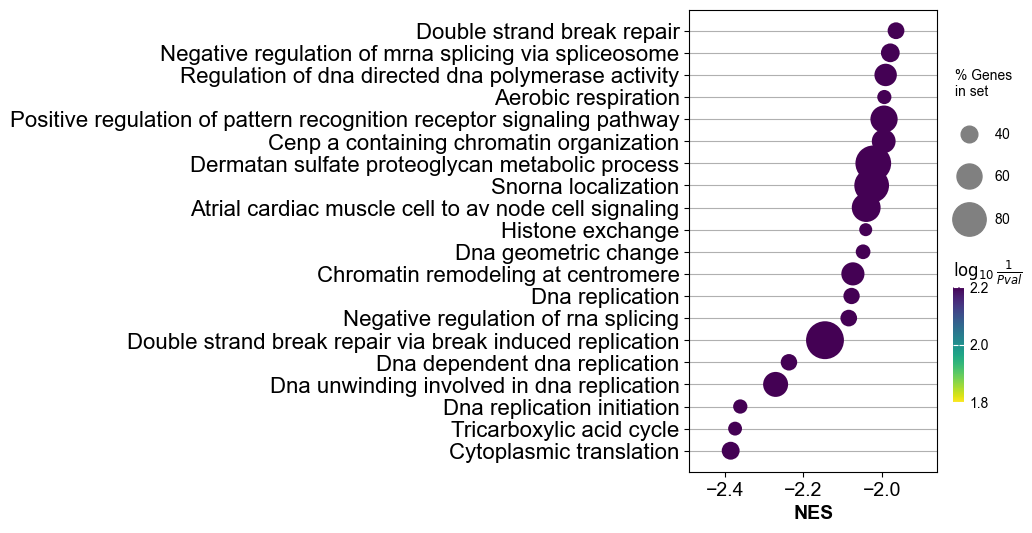

In [65]:
plot_data = filter_res.sort_values('NES').head(20)
plot_data['Term'] = [x.split('_',1)[1].replace('_', ' ').capitalize() for x in plot_data['Term']]

gp.dotplot(plot_data,column="NOM p-val",top_term=20)

A negative NES indicates that genes associated with a given Gene Ontology (GO) term are highly expressed at the start of the trajectory (i.e., cells with low NT scores).
For example, enrichment of DNA replication–related terms aligns with the potential of these cells to be preserved as RGCs in the next developmental stage (E16.5).

A positive NES indicates that GO term–associated genes are highly expressed at the end of the trajectory (i.e., cells with high NT scores).
Enrichment of terms related to neuron differentiation and CNS development corresponds to the potential differentiation of RGCs into mature neuronal states by E16.5.

## Regulon activity changes along spatial trajectory

To gain mechanistic insights, we performed gene regulatory network (GRN) analysis using the [SCENIC workflow](https://scenic.aertslab.org/) and explore regulon activity changes along spatial trajectory.


In [66]:
E14_RGC_regulon_aucell_df = regulon_aucell_df.loc[target_cells.index]
E14_RGC_regulon_aucell_df = E14_RGC_regulon_aucell_df.join(1-ana_data.NT_score['Cell_NTScore'] if hasattr(ana_data.options, 'reverse')
                       and ana_data.options.reverse else ana_data.NT_score['Cell_NTScore'])
E14_RGC_regulon_aucell_df.head()


,Ahr,Alx1,Alx3,Alx4,Ar,Arid3a,Arntl2,Arx,Atf1,Atf3,...,Zfp874b,Zfp941,Zfp944,Zfp979,Zic1,Zkscan14,Zkscan16,Zscan20,Zxdc,Cell_NTScore
Cell_ID,,,,,,,,,,,,,,,,,,,,,
E14_E1S3_171289,0.0,0.015500,0.014530,0.000000,0.0,0.003071,0.000000,0.072864,0.0,0.156601,...,0.001970,0.000000,0.0,0.0,0.026855,0.056960,0.023259,0.0,0.0,0.105795
E14_E1S3_171863,0.0,0.018301,0.017757,0.032068,0.0,0.003840,0.000000,0.000000,0.0,0.169815,...,0.004407,0.000000,0.0,0.0,0.092449,0.063594,0.026734,0.0,0.0,0.020465
E14_E1S3_171967,0.0,0.011018,0.009434,0.000000,0.0,0.001884,0.000000,0.071136,0.0,0.137201,...,0.018034,0.085787,0.0,0.0,0.033001,0.046866,0.017807,0.0,0.0,0.019447
E14_E1S3_171983,0.0,0.020709,0.000000,0.003596,0.0,0.000000,0.020299,0.099791,0.0,0.034300,...,0.000000,0.000000,0.0,0.0,0.054828,0.000000,0.000000,0.0,0.0,0.041343
E14_E1S3_172013,0.0,0.009773,0.008186,0.000000,0.0,0.001552,0.228530,0.000000,0.0,0.131016,...,0.000000,0.000000,0.0,0.0,0.045381,0.043549,0.016186,0.0,0.0,0.023282


In [67]:
E14_RGC_regulon_aucell_metacell_data_df = construct_meta_cell_along_trajectory(meta_data_df = E14_RGC_regulon_aucell_df,
                                                                trajectory = 'Cell_NTScore',
                                                                n_cells = 10)
E14_RGC_regulon_aucell_metacell_data_df.head()


,Ahr,Alx1,Alx3,Alx4,Ar,Arid3a,Arntl2,Arx,Atf1,Atf3,...,Zfp874b,Zfp941,Zfp944,Zfp979,Zic1,Zkscan14,Zkscan16,Zscan20,Zxdc,Cell_NTScore
Cell_ID,,,,,,,,,,,,,,,,,,,,,
E14_E1S3_173789,0.0,0.012552,0.019366,0.011585,0.000000,0.014612,0.004832,0.026460,0.0,0.138414,...,0.019770,0.0,0.0,0.000000,0.079209,0.051178,0.022155,0.0,0.0,0.000230
E14_E1S3_173259,0.0,0.019238,0.021671,0.014015,0.000000,0.003680,0.004246,0.011797,0.0,0.111139,...,0.017413,0.0,0.0,0.000000,0.055038,0.033917,0.016856,0.0,0.0,0.000240
E14_E1S3_174106,0.0,0.010374,0.022217,0.004985,0.014738,0.008334,0.023277,0.013118,0.0,0.117493,...,0.002832,0.0,0.0,0.015804,0.068224,0.063113,0.023028,0.0,0.0,0.000250
E14_E1S3_173417,0.0,0.024025,0.014273,0.005424,0.000000,0.005799,0.005877,0.000000,0.0,0.157988,...,0.002603,0.0,0.0,0.000000,0.046749,0.056830,0.028127,0.0,0.0,0.000266
E14_E1S3_173284,0.0,0.016657,0.011069,0.011577,0.014097,0.004353,0.021781,0.049954,0.0,0.122188,...,0.008053,0.0,0.0,0.019991,0.072346,0.039267,0.028010,0.0,0.0,0.000285


In [68]:
regulon_correlated_df = cal_features_correlation_along_trajectory(
    data_df = E14_RGC_regulon_aucell_metacell_data_df,
    trajectory = 'Cell_NTScore',
    rho_threshold=0.4,
    p_val_threshold=0.01
)
print(regulon_correlated_df.shape)

(10, 2)


/sc/arion/work/wangw32/conda-env/envs/ONTraC/lib/python3.11/site-packages/ONTraC/analysis/trajectory.py:102: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_val = pearsonr(data_df[trajectory], data_df[feat])


In [69]:
regulon_correlated_df.head()

,PCC,P_Value
Feature,,
Nfatc4,0.525306,0.000090
Lhx2,0.501632,0.000206
Neurod1,0.476846,0.000464
Sox6,0.414478,0.002767
Tcf7l2,0.402664,0.003743


### Diagnosis of Selected Regulons

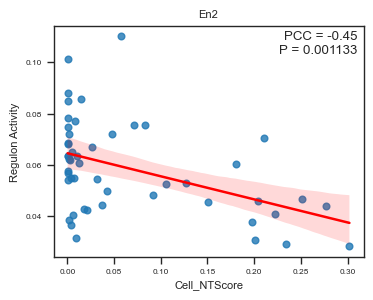

In [70]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_regulon_aucell_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'En2',
    fit_reg = True,
    annotate_pos = 'upper right',
    figszie = (4,3),
    ylabel = 'Regulon Activity',
    ci = 95,
)

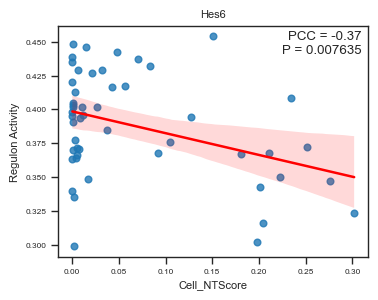

In [71]:
fig, ax = plot_scatter_feat_along_trajectory(
    data_df = E14_RGC_regulon_aucell_metacell_data_df,
    trajectory = 'Cell_NTScore',
    feature = 'Hes6',
    fit_reg = True,
    annotate_pos = 'upper right',
    figszie = (4,3),
    ylabel = 'Regulon Activity',
    ci = 95,
)

We identified several regulons whose activity scores are significantly correlated with cell-level NT scores (spatial trajectory).

## Session Info

In [72]:
import session_info

session_info.show()